In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re

In [7]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from skimage import color, io

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
from PIL import Image

# Increase the maximum allowed image pixels
Image.MAX_IMAGE_PIXELS = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


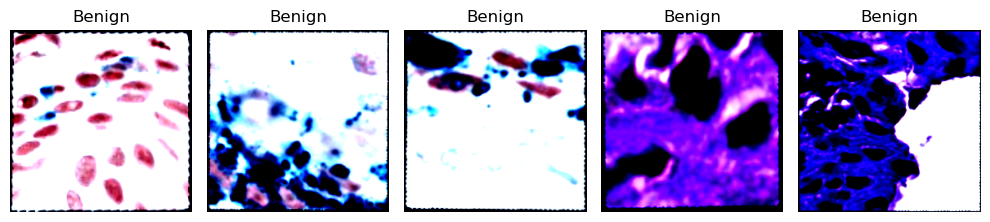

In [17]:
# Select only specified cases
benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
high_grade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]
selected_cases = benign_cases + high_grade_cases

# Load and clean labels
labels = pd.read_csv('/Users/harveywang/Downloads/case_grade_match.csv')
labels = labels.drop(index=64, errors='ignore').reset_index(drop=True)

# Group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num in selected_cases:
                case_patches.setdefault(case_num, []).append(os.path.join(patch_dir, filename))
    return case_patches

# Dataset class
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for case_num, patches in case_patches.items():
            label_row = labels_df[labels_df['Case'] == case_num]
            if not label_row.empty:
                label = label_row['Class'].values[0]
                if label == 1:  # Benign
                    binary_label = 0
                elif label == 3:  # High-grade
                    binary_label = 1
                else:
                    continue  # Skip low-grade or unknown
                for patch_path in patches:
                    self.image_paths.append(patch_path)
                    self.labels.append(binary_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load filtered patches
image_folder_path = '/Users/harveywang/Library/CloudStorage/GoogleDrive-harveywang2026@u.northwestern.edu/My Drive/Northwestern/Coursework/2025 Spring/STAT 390/CMIL_SP2025_Patches_Apr16'
patches = group_patches(image_folder_path)

# Filter labels
filtered_labels = labels[labels['Case'].isin(selected_cases)].reset_index(drop=True)

# Prepare binary label column for stratified split
filtered_labels = filtered_labels[filtered_labels['Class'].isin([1.0, 3.0])]
filtered_labels['BinaryClass'] = filtered_labels['Class'].map({1.0: 0, 3.0: 1})

X = filtered_labels['Case']
y = filtered_labels['BinaryClass']

# Stratified split
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Match patch files
train_patches = {int(case): patches[int(case)] for case in train_X if int(case) in patches}
val_patches = {int(case): patches[int(case)] for case in val_X if int(case) in patches}
test_patches = {int(case): patches[int(case)] for case in test_X if int(case) in patches}

# Create datasets and loaders
train_dataset = PNGDataset(train_patches, filtered_labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, filtered_labels, transform=eval_transform)
test_dataset = PNGDataset(test_patches, filtered_labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize sample images
images, labels_batch = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels_batch[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [18]:
# Define validation loss and accuracy

def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [25]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5,
                scheduler=None, resume_from=None, device='cuda' if torch.cuda.is_available() else 'cpu'):

    train_losses = []
    val_losses = []
    val_accuracies = []

    model_dir = "./models_5_4"
    os.makedirs(model_dir, exist_ok=True)

    model.to(device)
    best_acc = 0
    start_epoch = 0

    # Resume from checkpoint if specified
    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for images, labels in train_bar:
            images = [img.to(device) for img in images]
            labels = labels.to(device)
            images = torch.stack(images)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)

        # Step the learning rate scheduler if present
        if scheduler:
            scheduler.step()

        # Validation
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            correct = 0
            total = 0

            for images, labels in val_loader:
                images = [img.to(device) for img in images]
                labels = labels.to(device)
                images = torch.stack(images)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_val_loss = validation_loss / len(val_loader)
            val_accuracy = correct / total

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.3f}.. "
            f"Val Loss: {avg_val_loss:.3f}.. "
            f"Val Accuracy: {val_accuracy:.3f}"
        )

        # Save checkpoint
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"model_epoch_{e+1}.pth"))

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pth"))
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

        train_losses.append(epoch_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [26]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"../checkpoint/{timestamp}_{arch}.pth")
     

In [27]:
# CBAM Module
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction_ratio, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()

        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, stride=1, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.shared_mlp(self.avg_pool(x).view(b, c))
        max_out = self.shared_mlp(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_att

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))
        x = x * spatial_att
        return x

In [28]:
#EfficientNetB3 + CBAM Model
class EfficientNetB3_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetB3_CBAM, self).__init__()
        base_model = models.efficientnet_b3(weights='IMAGENET1K_V1')
        self.features = base_model.features
        self.cbam = CBAM(channels=1536)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
    
model = EfficientNetB3_CBAM(num_classes=2)

In [29]:
# Loss function: CrossEntropyLoss (expects raw logits)
criterion = nn.CrossEntropyLoss()

# Optimizer: only update the classifier (model.classifier.parameters())
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Epoch 1/5: 100%|██████████| 60/60 [31:36<00:00, 31.60s/it, loss=0.508]


Epoch: 1/5.. Train Loss: 0.508.. Val Loss: 0.387.. Val Accuracy: 0.866
✅ New best model saved at epoch 1 with accuracy 0.8658


Epoch 2/5: 100%|██████████| 60/60 [16:56<00:00, 16.94s/it, loss=0.397]


Epoch: 2/5.. Train Loss: 0.397.. Val Loss: 0.389.. Val Accuracy: 0.843


Epoch 3/5: 100%|██████████| 60/60 [18:49<00:00, 18.83s/it, loss=0.361]


Epoch: 3/5.. Train Loss: 0.361.. Val Loss: 0.387.. Val Accuracy: 0.845


Epoch 4/5: 100%|██████████| 60/60 [17:56<00:00, 17.95s/it, loss=0.329]


Epoch: 4/5.. Train Loss: 0.329.. Val Loss: 0.359.. Val Accuracy: 0.871
✅ New best model saved at epoch 4 with accuracy 0.8713


Epoch 5/5: 100%|██████████| 60/60 [18:04<00:00, 18.08s/it, loss=0.308]


Epoch: 5/5.. Train Loss: 0.308.. Val Loss: 0.366.. Val Accuracy: 0.863


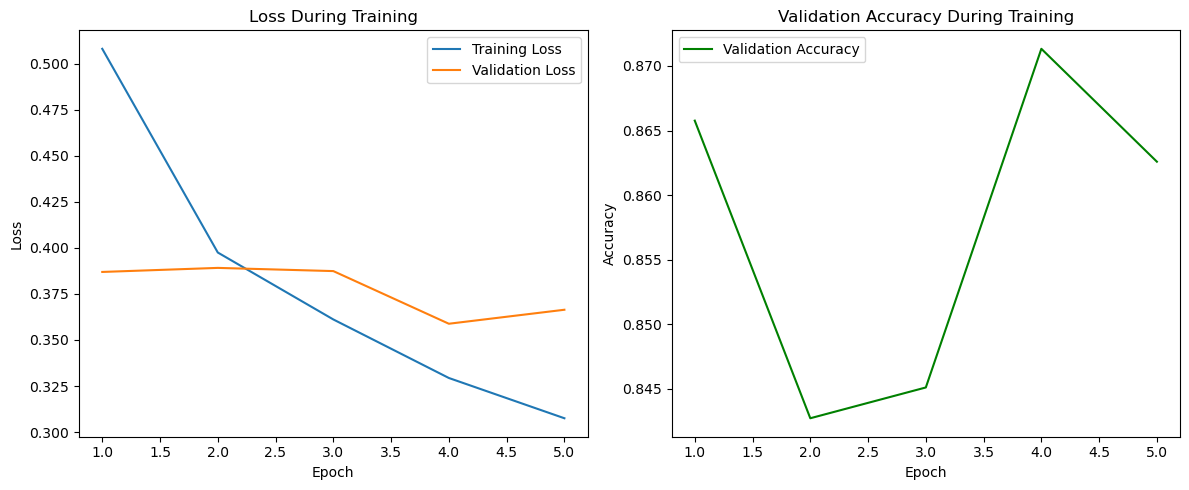

In [30]:
# Train model
efficientnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

In [33]:
def get_predictions(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [34]:
model.eval()

with torch.no_grad():
    predictions = []
    true_labels = []

    for images, labels in iter(test_loader):
        output = model.forward(images)
        probabilities = torch.exp(output)
        predictions += probabilities.max(dim=1)[1].tolist()
        true_labels += labels.tolist()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.41      0.95      0.58       248
           1       0.91      0.26      0.40       453

    accuracy                           0.50       701
   macro avg       0.66      0.61      0.49       701
weighted avg       0.73      0.50      0.47       701



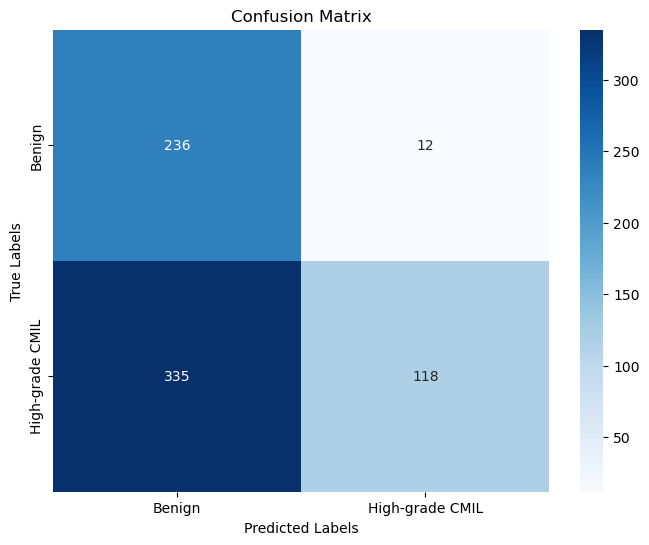

In [35]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
     

In [36]:

case_predictions = {}
case_true_labels = {}
case_accuracies = {}

# Create a dictionary to map image paths to case numbers
image_to_case = {}
for case_num, patches in test_patches.items():
    for patch in patches:
        image_to_case[patch] = case_num

# Iterate through the test dataset to map predictions back to case numbers
for i in range(len(test_dataset)):
    image_path, label = test_dataset[i]  # Access the image path and label directly from the dataset
    case_num = image_to_case[test_dataset.image_paths[i]]  # Use the image path to find the case number
    prediction = predictions[i]  # Access the prediction directly from the prediction list

    if case_num not in case_predictions:
        case_predictions[case_num] = []
        case_true_labels[case_num] = []
    case_predictions[case_num].append(prediction)
    case_true_labels[case_num].append(label)

for case_num, preds in case_predictions.items():
    correct_count = sum(1 for p, t in zip(preds, case_true_labels[case_num]) if p == t)
    accuracy = (correct_count / len(preds)) if len(preds) > 0 else 0  # Avoid division by zero
    case_accuracies[case_num] = accuracy

# Print the results
for case_num, accuracy in case_accuracies.items():
    true_label = case_true_labels[case_num][0]  # Get the true label for the case (all labels should be the same for a single case)
    true_label_name = 'Benign' if true_label == 0 else 'High-grade CMIL'  # Convert to label name
    print(f"Case {case_num}: Accuracy = {accuracy:.4f}, True Label = {true_label_name}")

Case 77: Accuracy = 0.9516, True Label = Benign
Case 92: Accuracy = 0.2605, True Label = High-grade CMIL


In [37]:
# Get true and predicted labels
true_labels, pred_labels = get_predictions(model, val_loader)  # or val_loader

Accuracy:  0.8626
Precision: 0.4113
Recall:    0.3919
F1 Score:  0.4014


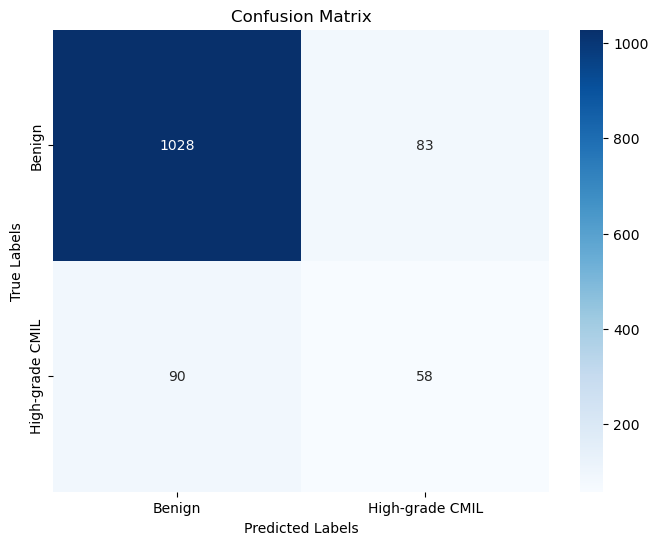

In [38]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# If binary classification, use average='binary'; for multiclass use 'macro' or 'weighted'
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')
accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()